# Part 1

Реализовать формулу подсчета длительности теста, сравнить ее с онлайн калькуляторами (например https://mindbox.ru/tools/ab-test-calculator/ ). При сравнении оценить мощность критерия при указанном изменении и рассчитанном количестве н-аблюдений в выборке

In [9]:
import numpy as np
import scipy.stats as sps

def duration(k, delta_effect, sigma_1, sigma_2, alpha=0.05, beta=0.2):
    z = sps.norm.ppf(1 - alpha/2) + sps.norm.ppf(1-beta)
    n = (k+1) * z ** 2 * (sigma_1 ** 2 + sigma_2 **2 / k) / (delta_effect ** 2)
    return n

In [10]:
# bernoulli similar to seminar

alpha = 0.05
prob = 0.2
powers = [0.8, 0.8, 0.6]
effects = [0.05, 0.1, 0.2]

for power, effect in zip(powers, effects):
    p_value_ttest = []
    p_value_mannwhitney = []
    n_exp = 10000

    sigma_1 = np.sqrt(prob * (1 - prob))
    sigma_2 = np.sqrt((prob + effect)  * (1 - prob - effect))

    test_duration = duration(k=1, delta_effect=effect, sigma_1=sigma_1, sigma_2=sigma_2, alpha=alpha, beta=1 - power)

    for i in range(n_exp):
        x_a = sps.bernoulli.rvs(p=prob, size=int(test_duration/2))
        x_b = sps.bernoulli.rvs(p=prob + effect, size=int(test_duration/2))
        p_value_ttest.append(sps.ttest_ind(x_a, x_b, equal_var=False).pvalue)
        p_value_mannwhitney.append(sps.mannwhitneyu(x_a, x_b).pvalue)

    p_value_ttest = np.array(p_value_ttest)
    p_value_mannwhitney = np.array(p_value_mannwhitney)

    print(f"effect: {effect}, power: {power}, duration: {test_duration}")
    print("ttest power:", len(p_value_ttest[p_value_ttest < alpha]) / len(p_value_ttest) * 100)
    print("mannwhitneyu power:", len(p_value_mannwhitney[p_value_mannwhitney < alpha]) / len(p_value_mannwhitney) * 100)
    print("expected_power:", power)

effect: 0.05, power: 0.8, duration: 2181.988566149046
ttest power: 80.23
mannwhitneyu power: 80.23
expected_power: 0.8
effect: 0.1, power: 0.8, duration: 580.8171003418325
ttest power: 79.75
mannwhitneyu power: 79.75
expected_power: 0.8
effect: 0.2, power: 0.6, duration: 97.9749194165774
ttest power: 56.47
mannwhitneyu power: 56.47
expected_power: 0.6


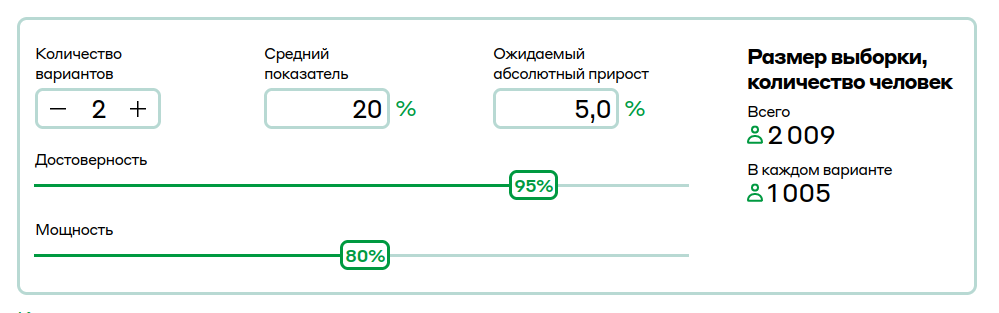

In [13]:
from IPython import display
display.Image("/home/nullkatar/Pictures/Screenshots/Screenshot from 2023-06-26 23-30-46.png")

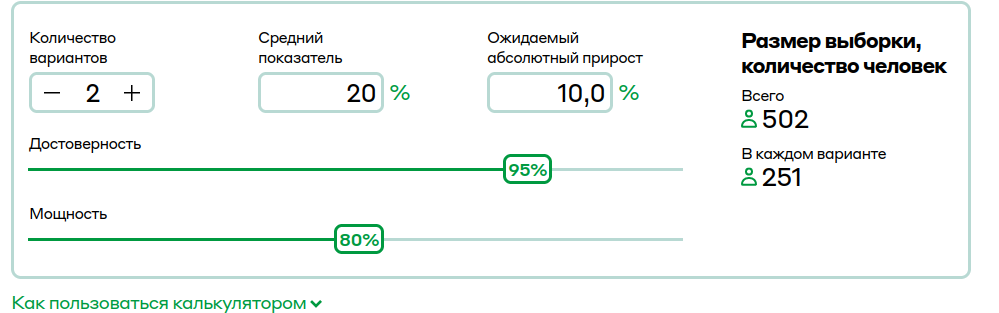

In [14]:
from IPython import display
display.Image("/home/nullkatar/Pictures/Screenshots/Screenshot from 2023-06-26 23-33-18.png")

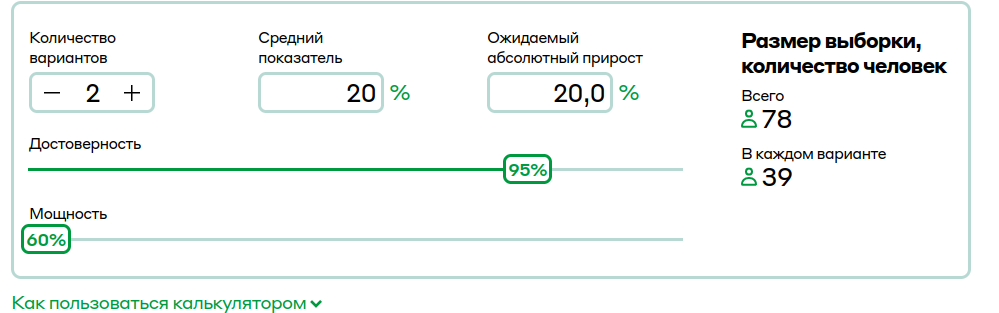

In [15]:
from IPython import display
display.Image("/home/nullkatar/Pictures/Screenshots/Screenshot from 2023-06-26 23-33-58.png")

# Part 2

Реализовать метод линеаризации. Проверить для него корректность и мощность. Мощность должна быть больше, чем просто на обычных значениях конверсии пользователей.

In [18]:
import pandas as pd
import plotly.graph_objs as go

#literally seminar code

def linearization(p, effect):
    n_exp = 1000
    p_values = []
    p_values_lin = []
    for _ in range(n_exp):
        records = []
        for i in range(100):
            n_views = int(sps.expon.rvs(loc=100, scale=100))
            clicks = sps.bernoulli.rvs(p=p, size=n_views)
            records.append([n_views, np.sum(clicks), np.sum(clicks)/ n_views, "A"])
        for i in range(100):
            n_views = int(sps.expon.rvs(loc=100, scale=100))
            clicks = sps.bernoulli.rvs(p=p + effect, size=n_views)
            records.append([n_views, np.sum(clicks), np.sum(clicks)/ n_views, "B"])
        df_data = pd.DataFrame(records, columns=["views", "clicks", "cr", "group"])

        cr_A = df_data[df_data["group"] == "A"]["clicks"].sum() / df_data[df_data["group"] == "A"]["views"].sum()
        df_data["cr_lin"] = df_data["clicks"] - cr_A * df_data["views"]

        x_a = df_data[df_data["group"] == "A"]["cr"]
        x_b = df_data[df_data["group"] == "B"]["cr"]
        p_value = sps.ttest_ind(x_a, x_b).pvalue
        p_values.append(p_value)

        x_a_lin = df_data[df_data["group"] == "A"]["cr_lin"]
        x_b_lin = df_data[df_data["group"] == "B"]["cr_lin"]
        p_value_lin = sps.ttest_ind(x_a_lin, x_b_lin).pvalue
        p_values_lin.append(p_value_lin)
    return p_values, p_values_lin

def get_qq_plot(p_values, title):
    p_values = np.array(p_values)
    probs = []
    x = [0.01 * i for i in range(101)]
    for i in range(101):
        alpha_step = 0.01 * i
        probs.append(p_values[p_values < alpha_step].shape[0] / p_values.shape[0])
    fig = go.Figure([go.Scatter(x=x, y=probs, mode="markers", name="p_value"),
                 go.Scatter(x=x, y=x, mode="lines", name="uniform")])
    fig.update_layout(height=600, width=600, title=title) 
    return fig

In [19]:
p_values, p_values_lin = linearization(0.05, 0)

In [20]:
get_qq_plot(p_values, title='without Linearization')

In [21]:
get_qq_plot(p_values_lin, title='with Linearization')

In [22]:
p_values, p_values_lin = linearization(0.05, 0.005)

p_values = np.array(p_values)
p_values_lin = np.array(p_values_lin)

print("power without Linearization VS with Linearization:",
      p_values[p_values < alpha].shape[0] / p_values.shape[0] * 100,
      p_values_lin[p_values_lin < alpha].shape[0] / p_values_lin.shape[0] * 100)


power without Linearization VS with Linearization: 48.9 56.00000000000001


# Part 3

Реализовать метод CUPED. Проверить для него корректность и мощность. Данные на этапе до A/B тесте необходимо сгенерировать один раз, далее синтетически генерировать только часть, связанную с проведением A/B-теста.

In [ ]:
size = 10000
pre_exp = sps.norm.rvs(loc=100, scale=20, size=size)

In [24]:
#literally seminar code
n_exp = 1000
p_values = []
p_values_cuped = []

# Pre_experiment
for _ in range(n_exp):
    df_A = pd.DataFrame()
    df_A["user"] = [f"A_{x:5}" for x in range(size)]
    df_A["pre_exp"] = pre_exp
    df_B = pd.DataFrame()
    df_B["pre_exp"] = pre_exp
    df_B["user"] = [f"B_{x:5}" for x in range(size)]
    df_A["payments"] = sps.expon.rvs(loc=100, scale=100, size=size) * df_A["pre_exp"]
    df_B["payments"] = sps.expon.rvs(loc=100, scale=100, size=size) * df_B["pre_exp"]

    p_values.append(sps.ttest_ind(df_A["payments"], df_B["payments"]).pvalue)

    x_a = df_A["pre_exp"]
    x_b = df_B["pre_exp"]
    y_a = df_A["payments"]
    y_b = df_B["payments"]
    theta = np.cov(x_a, y_a)[0,1] / np.std(x_a)**2

    df_A["payments_cuped"] = df_A["payments"] - theta * df_A["pre_exp"]
    df_B["payments_cuped"] = df_B["payments"] - theta * df_B["pre_exp"]

    p_values_cuped.append(sps.ttest_ind(df_A["payments_cuped"], df_B["payments_cuped"]).pvalue)


In [25]:
get_qq_plot(p_values_cuped, title='Cuped')

In [26]:
#literally seminar code

effect = 0.005
n_exp = 1000
p_values = []
p_values_cuped = []

# Pre_experiment
for _ in range(n_exp):
    df_A = pd.DataFrame()
    df_A["user"] = [f"A_{x:5}" for x in range(size)]
    df_A["pre_exp"] = pre_exp
    df_B = pd.DataFrame()
    df_B["pre_exp"] = pre_exp
    df_B["user"] = [f"B_{x:5}" for x in range(size)]
    df_A["payments"] = sps.expon.rvs(loc=1, scale=100, size=size) * df_A["pre_exp"]
    df_B["payments"] = sps.expon.rvs(loc=1 + effect, scale=100, size=size) * df_B["pre_exp"]

    p_values.append(sps.ttest_ind(df_A["payments"], df_B["payments"]).pvalue)

    x_a = df_A["pre_exp"]
    x_b = df_B["pre_exp"]
    y_a = df_A["payments"]
    y_b = df_B["payments"]
    theta = np.cov(x_a, y_a)[0,1] / np.std(x_a)**2

    df_A["payments_cuped"] = df_A["payments"] - theta * df_A["pre_exp"]
    df_B["payments_cuped"] = df_B["payments"] - theta * df_B["pre_exp"]

    p_values_cuped.append(sps.ttest_ind(df_A["payments_cuped"], df_B["payments_cuped"]).pvalue)

p_values = np.array(p_values)
p_values_lin = np.array(p_values_lin)

print("power without CUPED VS with CUPED:",
      p_values[p_values < alpha].shape[0] / p_values.shape[0] * 100,
      p_values_lin[p_values_lin < alpha].shape[0] / p_values_lin.shape[0] * 100)


power without CUPED VS with CUPED: 4.8 56.00000000000001
